In [1]:
import seaborn as sns
import jax
import ott
import diffrax
import jax.numpy as jnp
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from entot.models.model import OTFlowMatching
from entot.nets.nets import MLP_vector_field, MLP_bridge, MLP_marginal
import sklearn.preprocessing as pp
import scanpy as sc
from ott.solvers.linear import sinkhorn, acceleration
from entot.data.data import MixtureNormalSampler
from entot.plotting.plots import plot_1D_unbalanced

/home/icb/dominik.klein/mambaforge/envs/entot_pip/lib/python3.11/site-packages/equinox/_ad.py:753: UserWarning: As of Equinox 0.10.7, `equinox.filter_custom_vjp.defvjp` is deprecated in favour of `.def_fwd` and `.def_bwd`. This new API supports symbolic zeros, which allow for more efficient autodifferentiation rules. In particular:
- the fwd and bwd functions take an extra `perturbed` argument, which     indicates which primals actually need a gradient. You can use this     to skip computing the gradient for any unperturbed value. (You can     also safely just ignore this if you wish.)
- `None` was previously passed to indicate a symbolic zero gradient for     all objects that weren't inexact arrays, but all inexact arrays     always had an array-valued gradient. Now, `None` may also be passed     to indicate that an inexact array has a symbolic zero gradient.
  warnings.warn(
/home/icb/dominik.klein/mambaforge/envs/entot_pip/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: I

In [2]:
source = MixtureNormalSampler(jax.random.PRNGKey(0), [0.0, 2.0], 1,  0.4, weights=[0.5, 0.5], batch_size=1024)
target = MixtureNormalSampler(jax.random.PRNGKey(1), [-1.0,1.0, 5.0], 1,  0.1, batch_size=1024)

In [3]:
epsilon = 5e-2
tau_a = 0.98
tau_b = 0.98

In [4]:
neural_net = MLP_vector_field(1, latent_embed_dim = 128, num_layers=3, n_frequencies=1024)
bridge_net = MLP_bridge(1, 1)

mlp_eta = MLP_marginal(256, 5)
mlp_xi = MLP_marginal(256, 5)
solver_latent_to_data = ott.solvers.linear.sinkhorn.Sinkhorn()
ot_solver = ott.solvers.linear.sinkhorn.Sinkhorn()

otfm = OTFlowMatching(neural_net, bridge_net=bridge_net, ot_solver=ot_solver, solver_latent_to_data=solver_latent_to_data, epsilon=epsilon, mlp_eta=mlp_eta, mlp_xi=mlp_xi, tau_a=tau_a, tau_b=tau_b, input_dim=1, output_dim=1, iterations=10_000, k_noise_per_x=10)

In [5]:
otfm(source, target, 1024, 1024)

100%|██████████| 10000/10000 [12:00<00:00, 13.88it/s]


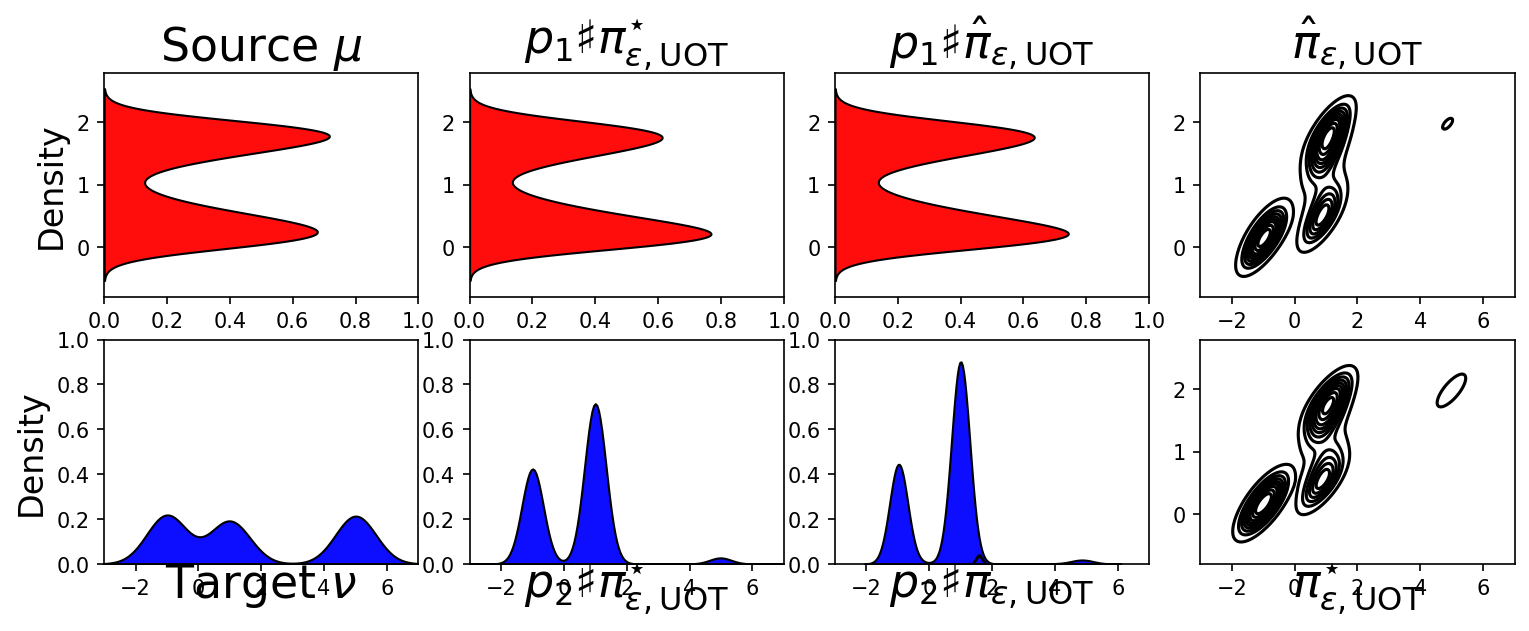

In [6]:
kwargs = {}
a = (-0.8, 2.8) # source support
b = (0.0, 1.0) # density plot
c = (0.0, 4.0)
d = (-3.0, 7.0) # target support
kwargs["00_xlim"] = b
kwargs["01_xlim"] = b
kwargs["02_xlim"] = b
kwargs["03_xlim"] = d
kwargs["10_xlim"] = d
kwargs["11_xlim"] = d
kwargs["12_xlim"] = d
kwargs["13_xlim"] = d

kwargs["00_ylim"] = a
kwargs["01_ylim"] = a
kwargs["02_ylim"] = a
kwargs["03_ylim"] = a
kwargs["10_ylim"] = b
kwargs["11_ylim"] = b
kwargs["12_ylim"] = b
kwargs["13_ylim"] = a

source_batch = next(source)
target_batch = next(target)

rescale_source = otfm.state_eta.apply_fn({"params": otfm.state_eta.params}, source_batch)
rescale_target = otfm.state_xi.apply_fn({"params": otfm.state_xi.params}, target_batch)

res, _, _ = otfm.transport(source_batch, seed=1, diffeqsolve_kwargs={"max_steps": 1_000_000})

fig = plot_1D_unbalanced(source_batch, target_batch, res[0,...], rescale_source, rescale_target, epsilon=epsilon, tau_a=tau_a, tau_b=tau_b, seed=1, figsize=(10,4), dpi=150, **kwargs)


In [7]:

source_const_1 = np.ones((1000,1)) * 1.97
source_const_2 = np.ones((1000,1)) * 0.33

source_const = np.concatenate((source_const_1, source_const_2), axis=0)

In [8]:
res_const, _, _ = otfm.transport(source_const, seed=1, diffeqsolve_kwargs={"max_steps": 1_000_000})
rescale_source_const = otfm.state_eta.apply_fn({"params": otfm.state_eta.params}, source_const)

In [9]:
import pandas as pd
df = pd.DataFrame(res_const[0], columns = ["transported"])
df["source"] = source_const
df["source_cat"] = df["source"].astype('category')
df["eta"] = rescale_source_const

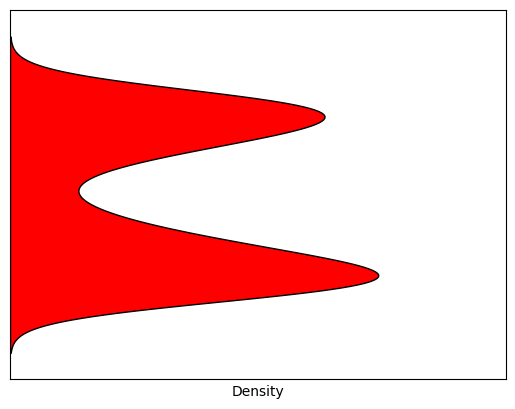

In [10]:
a = (-0.8, 2.8) # source support
b = (0.0, 1.0) # density plot
c = (0.0, 4.0)
d = (-3.0, 7.0) # target support


g = sns.kdeplot(y=source_batch[:, 0],
            color="r",
            fill=True,
            edgecolor="black",
            weights=rescale_source[:,0],
            alpha=1.0,
        )
g.set_xlim(b)
g.set_ylim(a)
g.tick_params(left = False, right = False , labelleft = False ,labelbottom = False, bottom = False)


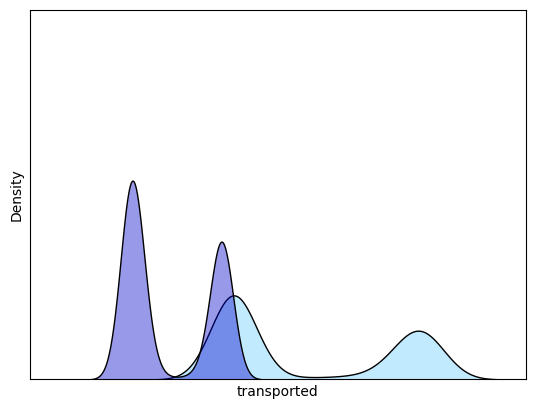

In [11]:
g = sns.kdeplot(df,
            x="transported",
            hue="source_cat",
            palette={0.33: "#0000cc", 1.97:"#66ccff"},
            fill=True,
            edgecolor="black",
            alpha=0.4,
            weights="eta",
        )
g.set_xlim(d)
g.set_ylim(b)
g.tick_params(left = False, right = False , labelleft = False ,labelbottom = False, bottom = False)
g.get_legend().remove()

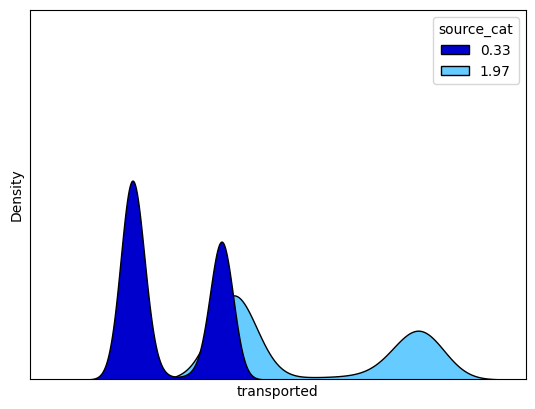

In [12]:
g = sns.kdeplot(df,
            x="transported",
            hue="source_cat",
            palette={0.33: "#0000cc", 1.97:"#66ccff"},
            fill=True,
            edgecolor="black",
            alpha=1.0,
            weights="eta",
        )
g.set_xlim(d)
g.set_ylim(b)
g.tick_params(left = False, right = False , labelleft = False ,labelbottom = False, bottom = False)


In [27]:
def compute_densities(source: jnp.ndarray, compute_densities_at: jnp.ndarray, rng: jax.Array, approx=True):

    def normal_log_likelihood(y):
        return -0.5 * (y.size * math.log(2 * math.pi) + jnp.sum(y**2))

    def compute_p(target: jnp.ndarray, eps: jnp.ndarray):
        def approx_logp_wrapper(t, y, args):
            y, _ = y
            *args, eps, func = args
            fn = lambda x: func(t=t, latent=x)
            f, vjp_fn = jax.vjp(fn, y)
            (eps_dfdy,) = vjp_fn(eps)
            logp = jnp.sum(eps_dfdy * eps)
            return f, logp

        def exact_logp_wrapper(t, y, args):
            y, _ = y
            y = jnp.atleast_2d(y)[0,:]
            *args, _, func = args
            fn = lambda x: func(t=t, latent=x)
            f, vjp_fn = jax.vjp(fn, y)
            eye = jnp.eye(y.shape[-1])[:,None]
            (dfdy,) = jax.vmap(vjp_fn)(eye)
            logp = jnp.trace(dfdy)
            return f, logp
        
        fn_partial = partial(
                otfm.state_neural_net.apply_fn, {"params": otfm.state_neural_net.params}, condition=source,
            )
        
        term = diffrax.ODETerm(approx_logp_wrapper) if approx else diffrax.ODETerm(exact_logp_wrapper)
        t0=0.0
        t1=1.0
        dt0=0.00001
        eps = jnp.atleast_2d(eps)
        target = jnp.atleast_2d(target)
        x1_f1_stacked = (target, 0.0)
        solver = diffrax.Tsit5()
        saveat = diffrax.SaveAt(ts=jnp.linspace(1, 0, 11))
        
        sol = diffrax.diffeqsolve(
            term, solver, t1, t0, -dt0, x1_f1_stacked, (eps, fn_partial), saveat=saveat, stepsize_controller=diffrax.PIDController(rtol=1e-3, atol=1e-6)#, saveat=saveat
        )
        return sol.ys

    eps = jax.random.normal(rng, (1,))
    eps = jnp.ones_like(compute_densities_at) * eps
    compute_p_vmapped = jax.vmap(compute_p)
    out = compute_p_vmapped(compute_densities_at, eps)
    x_0 = jnp.squeeze(jnp.asarray(out[0]))
    f_0 = jnp.squeeze(jnp.asarray(out[1]))
    print(x_0.shape, f_0.shape)
    target_dim = compute_densities_at.shape[-1]
    logl = jax.scipy.stats.norm.logpdf(x_0, 1.0, 1.0)
    ps = jnp.exp(logl+f_0)
    return x_0, f_0, ps


In [59]:
compute_densities_at = jnp.linspace(-3.0, 7.0, 1000)[:, None]
sources = jnp.array([[0.33], [1.94]])

In [60]:
from functools import partial
import math
x_0s, f_0s, outs = [], [], []
for i in range(len(sources)):
    x_0, f_0, out = compute_densities(sources[i][:,None], compute_densities_at, jax.random.PRNGKey(0), approx=False)
    x_0s.append(x_0)
    f_0s.append(f_0)
    outs.append(out)

(1000, 11) (1000, 11)
(1000, 11) (1000, 11)


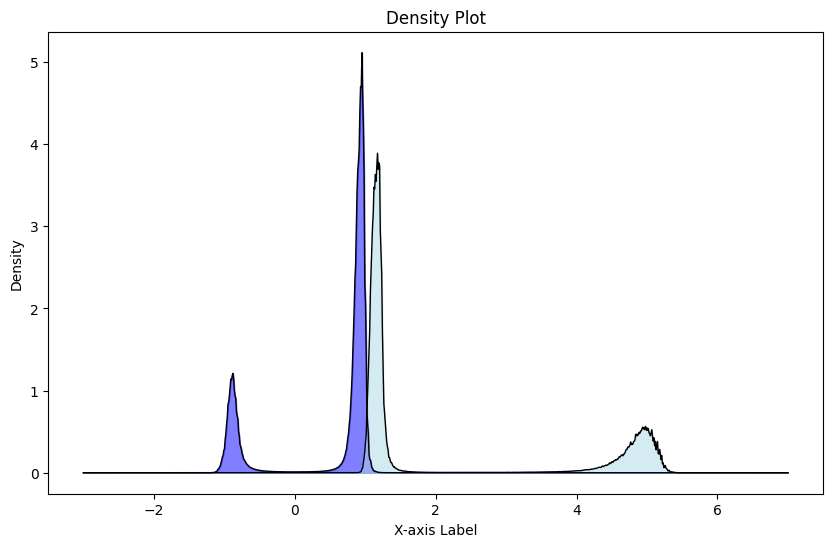

In [61]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))

# Plotting the line plot
plt.plot(compute_densities_at, outs[0][:,-1], color='black', linestyle='-', linewidth=1)
plt.plot(compute_densities_at, outs[1][:,-1], color='black', linestyle='-', linewidth=1)

plt.fill_between(compute_densities_at[:,0], outs[0][:,-1], color='blue', alpha=0.5)
plt.fill_between(compute_densities_at[:,0], outs[1][:,-1], color='lightblue', alpha=0.5)
# Add labels and title
plt.xlabel('X-axis Label')
plt.ylabel('Density')
plt.title('Density Plot')

# Show the plot
plt.show()
